<a href="https://colab.research.google.com/github/pelegrinoo/TinyML_ArdNanBLE33/blob/main/Arduino_TinyML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                              IMPLEMENTAÇÃO DE REDES NEURAIS ARTIFICIAIS COM ARDUINO NANO BLE 33 PARA IDENTIFICAÇÃO DE GESTOS

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

O código a seguir demosntra como realizar a implementação de redes neurais artificiais no Microcontrolador Arduino Nano BLE 33
<br><br>**SÃO 4 TIPOS DE GESTOS :**
>Soco
<br>Flexão do braço
<br>Movimento para a Direita
<br>Movimento para a Esquerda

---

**OBS! : Essa etapa só é feita após o salvamento dos arquivos em .CSV através dos dados coletados do monitor serial da IDE do Arduino**
<br><br>

---

### Bibliotecas utilizadas

In [ ]:
import os
import math                        # Biblioteca com funções matemáticas
import numpy             as np     # Biblioteca com funções matemáticas
import pandas            as pd     # Biblioteca para manipulação e análise de dados
import pickle            as pic    # Biblioteca para salvar e carregar dados
import matplotlib.pyplot as plt    # Biblioteca com ferramentas de plotagem de gráficos

import warnings                    # Biblioteca para evitar avisos

import tensorflow as tf            # Importa tensorflow para aprendizado de máquina

from sklearn.metrics         import confusion_matrix  # Biblioteca para calcular a matriz de confusão
from sklearn.preprocessing   import MinMaxScaler      # Biblioteca para normalizar os dados
from sklearn.model_selection import train_test_split  # Biblioteca para dividir os dados em conjuntos de treinamento e teste

### Funções Disponíveis

Cria dataset, seja para `treino`, `teste` ou `validação`

In [ ]:
def create_dataset(X, y, batch_size):

    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.batch(batch_size)
    return dataset

Plota o resultado do modelo treinado

In [ ]:
def plot_model(accuracy, val_accuracy, loss, val_loss, epochs):

    epochs_range = range(epochs)

    plt.gcf().clear()
    plt.figure(figsize=(12,4))

    plt.subplot(1, 2, 1)
    plt.title('Training and Validation Accuracy')
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.title('Training and Validation Loss')
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='lower right')

    plt.show()

Cria a matriz de confusão com base nos resultados e número de classes

In [ ]:
def matriz_confusao(y_true, y_pred, classes):

  cm = confusion_matrix(y_true, y_pred)

  # Define as classes do modelo
  classes_ = classes

  # Cria a figura e o eixo da matriz de confusão
  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  ax.figure.colorbar(im, ax=ax)

  # Adiciona os rótulos dos eixos
  ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes_, yticklabels=classes_,
        ylabel='Verdadeiro',
        xlabel='Previsto')

  # Adiciona as anotações dos valores na matriz
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], 'd'),
                  ha="center", va="center",
                  color="white" if cm[i, j] > thresh else "black")

  plt.title("Matriz de Confusão")
  plt.show()

Normalizador dos dados de `acelerômetro` e `giroscópio`

In [ ]:
def normalize_df(df, acc_range, gyro_range):
    df_norm = df.copy()
    df_norm[['aX', 'aY', 'aZ']] = (df[['aX', 'aY', 'aZ']] - acc_range[0])  / (acc_range[1]  - acc_range[0])
    df_norm[['gX', 'gY', 'gZ']] = (df[['gX', 'gY', 'gZ']] - gyro_range[0]) / (gyro_range[1] - gyro_range[0])
    return df_norm

### Salvamento dos dados nas variáveis respectivas

>**OBS:** É preciso importar manualmente na aba lateral esquerda os arquivos `.csv` clicando no ícone de pasta e de upload de arquivo

Armazena os dados em cada variável

In [ ]:
path_soco     = "/content/Soco.csv"
path_flexao   = "/content/Flexao.csv"
path_direita  = "/content/Direita.csv"
path_esquerda = "/content/Esquerda.csv"

Leitura de um dos arquivos e display para mostrar um exemplo do formato dos dados

In [ ]:
dt_soco = pd.read_csv(path_soco).dropna()

display(dt_soco)

,aX,aY,aZ,gX,gY,gZ
0,-1.730,0.514,1.498,25.330,30.945,0.793
1,-1.947,0.648,1.567,32.043,35.583,-2.136
2,-2.112,0.756,1.658,41.077,35.950,-4.272
3,-2.224,0.807,1.723,48.523,27.222,-4.028
4,-2.305,0.828,1.706,49.744,6.714,-3.113
...,...,...,...,...,...,...
1185,-0.171,0.270,1.031,0.610,-5.615,-6.042
1186,-0.128,0.285,0.984,-0.977,-6.348,-8.606
1187,-0.116,0.278,0.963,1.587,-8.118,-10.010
1188,-0.101,0.250,0.997,5.310,-8.362,-9.644


Salvamento do restante dos dados em suas respectivas variáveis

In [ ]:
dt_felxao   = pd.read_csv(path_flexao).dropna()
dt_direita  = pd.read_csv(path_direita).dropna()
dt_esquerda = pd.read_csv(path_esquerda).dropna()

### Plot dos gráficos de acelerômetro e giroscópio para dados de Soco **(OPICIONAL)**

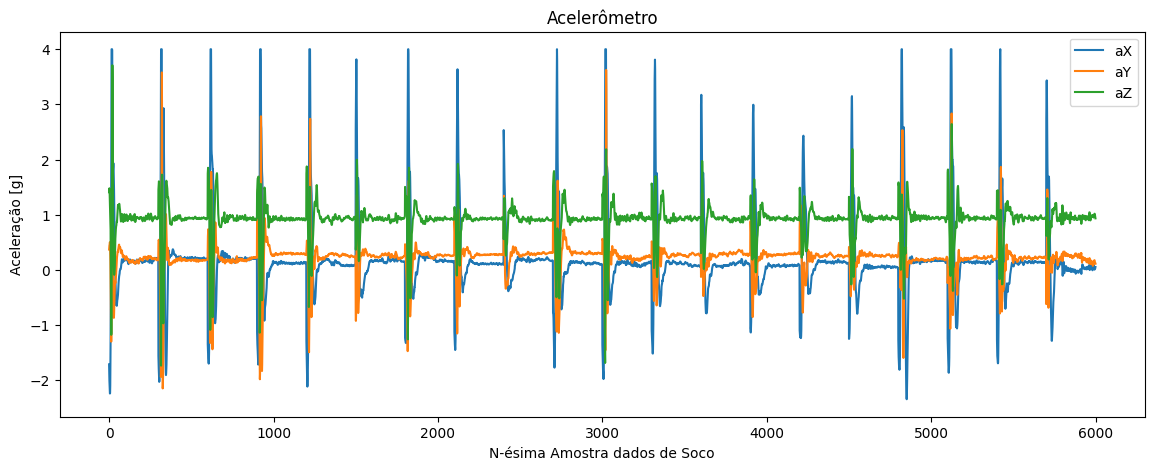

In [ ]:
plt.rcParams["figure.figsize"] = (14,5)

for i in range(len(dt_soco.columns[:3])):

  plt.plot(list(range(len(dt_soco[dt_soco.columns[:3][i]]))), dt_soco[dt_soco.columns[:3][i]], label = dt_soco.columns[:3][i])

plt.title("Acelerômetro")
plt.xlabel("N-ésima Amostra dados de Soco")
plt.ylabel("Aceleração [g]")

plt.legend()
plt.show()

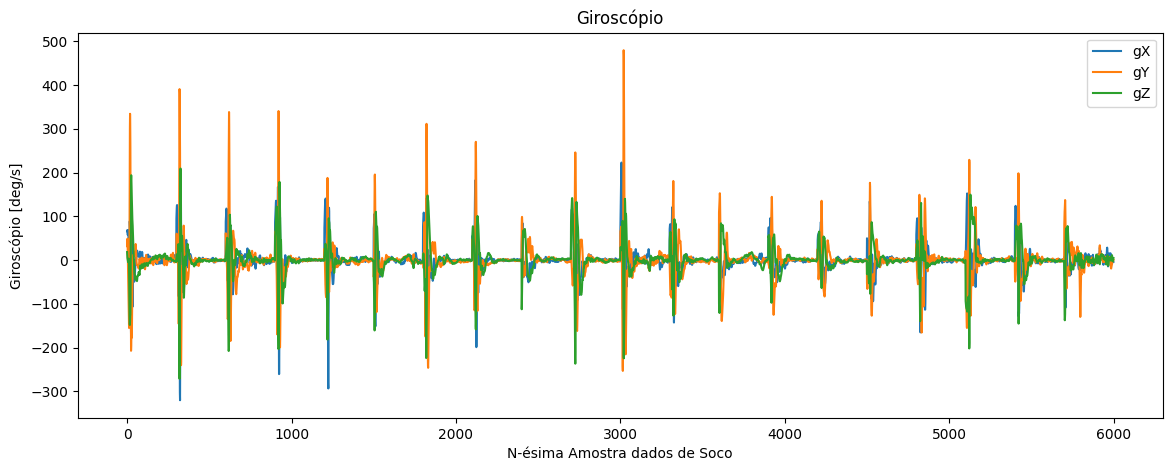

In [ ]:
plt.rcParams["figure.figsize"] = (14,5)

for i in range(len(dt_soco.columns[3:])):

  plt.plot(list(range(len(dt_soco[dt_soco.columns[3:][i]]))), dt_soco[dt_soco.columns[3:][i]], label = dt_soco.columns[3:][i])

plt.title("Giroscópio")
plt.xlabel("N-ésima Amostra dados de Soco")
plt.ylabel("Giroscópio [deg/s]")

plt.legend()
plt.show()

### Normalização dos dados e finalização dos `dataframes (df)`

In [ ]:
acceleration_range = (-4, 4)
gyroscope_range    = (-2000, 2000)

df_soco_norm = normalize_df(dt_soco, acceleration_range, gyroscope_range)
df_felxao_norm = normalize_df(dt_felxao, acceleration_range, gyroscope_range)
df_direita_norm = normalize_df(dt_direita, acceleration_range, gyroscope_range)
df_esquerda_norm = normalize_df(dt_esquerda, acceleration_range, gyroscope_range)

### Criação dos dados de entrada e de saída

Salva os dfs em uma variável única

In [ ]:
dataframes = [df_soco_norm, df_felxao_norm, df_direita_norm, df_esquerda_norm]

Aplica o `One-Hot-Encoded (OHE)` na variável que recebe o nome de cada gesto e printa a matriz com os binários

In [ ]:
gestos = ['Soco', 'Flexao', 'Direita', 'Esquerda']

OHE_gestos = np.eye(len(gestos))

print(OHE_gestos)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


Percorre os dfs e a matriz OHE e gera os dados de entrada `X` e de saída `Y`

In [ ]:
entradas = []
saidas   = []

amostras_gestos = 119

for i, df in enumerate(dataframes):

    num_recordings = df.shape[0] // amostras_gestos
    saida_gesto = OHE_gestos[i]

    for j in range(num_recordings):

        tensor = df.values[j * amostras_gestos: (j + 1) * amostras_gestos].flatten().tolist()

        entradas.append(tensor)
        saidas.append(saida_gesto.tolist())

X = np.array(entradas)
Y = np.array(saidas)

print(f"Entradas (X) shape: {X.shape}")
print(f"Saídas   (Y) shape: {Y.shape}")

Entradas (X) shape: (40, 714)
Saídas   (Y) shape: (40, 4)


Faz toda a divisão dos dados para `Treino`, `Teste` e `Validação`

In [ ]:
divisao_treino = 0.60
divisao_testes = 0.20
divisao_valida = 1 - divisao_treino - divisao_testes

X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size = (divisao_testes + divisao_valida), shuffle=True)

taxa_divisao_teste = divisao_testes / (divisao_testes + divisao_valida)

X_test, X_validate, y_test, y_validate = train_test_split(X_temp, y_temp, test_size = taxa_divisao_teste, shuffle=True)

print(f"Shape dos dados de treinamento: {X_train.shape}")
print(f"Shape dos dados de teste: {X_test.shape}")
print(f"Shape dos dados de validação: {X_validate.shape}")

Shape dos dados de treinamento: (24, 714)
Shape dos dados de teste: (8, 714)
Shape dos dados de validação: (8, 714)


### Define o informações para o treino e gera os `datasets`

Definição de alguns argumentos
>*batch_size* : tamanho dos "pacotes" de aprendizado
<br>*epocas* : número de épocas para os treinamentos
<br>*taxa_aprendizado* : taxa de aprendizado de máquina

In [ ]:
batch_size = 8
epocas = 100
taxa_aprendizado = 0.001

Criação dos datasets

In [ ]:
dataset_train = create_dataset(X_train, y_train, batch_size)
dataset_test = create_dataset(X_test, y_test, batch_size)
dataset_validate = create_dataset(X_validate, y_validate, batch_size)

### Gera e treina o modelo `Dense Neural Network (DNN)` ou Rede Neural Densa

#### Modelo 1:
>*Otimizador: Adam*
<br>*Métrica: Loss*
<br>*Batch_size: 32*
<br>*Épocas: 30*
<br>*Learning_rate: 0.001*
<br>*Camadas: 2 - 128 Neurônios | 4 Neurônios*

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)

DNN_model_Adam = tf.keras.models.Sequential([

    # Construção dos neurônios
    tf.keras.layers.Dense(128, activation = 'relu', input_shape = (X_train.shape[1],)),
    tf.keras.layers.Dense(len(gestos), activation = 'softmax')

])

DNN_model_Adam.compile(

    optimizer = tf.keras.optimizers.Adam(learning_rate = taxa_aprendizado),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']

)

DNN_model_Adam.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                     │ (None, 128)                 │          91,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,036 (359.52 KB)

 Trainable params: 92,036 (359.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_DNN_Adam = DNN_model_Adam.fit(

    dataset_train,
    validation_data = dataset_validate,
    epochs = epocas

)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step - accuracy: 0.2917 - loss: 1.5613 - val_accuracy: 0.1250 - val_loss: 1.6130
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2917 - loss: 1.5890 - val_accuracy: 0.3750 - val_loss: 1.4396
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2083 - loss: 1.5292 - val_accuracy: 0.1250 - val_loss: 1.4975
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2917 - loss: 1.3392 - val_accuracy: 0.1250 - val_loss: 1.6130
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2917 - loss: 1.3176 - val_accuracy: 0.5000 - val_loss: 1.5734
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7083 - loss: 1.3113 - val_accuracy: 0.5000 - val_loss: 1.4984
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4583 - loss: 1.3237 - val_accuracy: 0.5000 - val_loss: 1.3762
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4583 - loss: 1.2555 - val_accuracy: 0.6250 - val_loss: 1.2545

Faz uma avaliação do modelo com dados de teste

In [ ]:
dataset_test_loss, dataset_test_accuracy = DNN_model_Adam.evaluate(dataset_test)

classes = ['Loss', 'Acurácia']
indices = ['Valor']
acuracia = np.around(100*dataset_test_accuracy,2)

dados_tab = [[np.around(dataset_test_loss,4), f'{np.around(100*dataset_test_accuracy,2)}%']]

tabela = pd.DataFrame(dados_tab, index = indices, columns = classes)

display(tabela)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.6309


,Loss,Acurácia
Valor,0.6309,100.0%


Teste de fato com os dados de teste e obtém os valores `previstos`e `esperados`

In [ ]:
predictions = DNN_model_Adam.predict(X_test)
predictions = np.argmax(predictions, axis=1)

esperado = np.argmax(y_test, axis=1)

incremento = 0
previsao   = predictions

for i in range(len(previsao)):
  if previsao[i] == esperado[i]:
    incremento = incremento + 1

print('\nResultados Esperados: %s' % esperado)
print('\nResultados Previstos: %s' % predictions)
print('\nTeste teve {}% de aproveitamento\n'.format(round((incremento/len(previsao))*100,2)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Resultados Esperados: [1 0 2 3 1 3 2 0]

Resultados Previstos: [1 0 2 3 1 3 2 0]

Teste teve 100.0% de aproveitamento



Salva o histórico do treinamento no próprio ambiente

In [ ]:
with open('/content/history_DNN_Adam.pkl', 'wb') as f:
  pic.dump(history_DNN_Adam.history, f)

print(f"Histórico de treinamento salvo no Colab")

Histórico de treinamento salvo no Colab


Abre o histórico do treinamento

In [ ]:
with open('/content/history_DNN_Adam.pkl', 'rb') as f:
  loaded_history = pic.load(f)

print(f"Histórico de treinamento carregado do Colab")

Histórico de treinamento carregado do Colab


Armazena nas variáveis as `acurácias` e `losses` de treino e validação

In [ ]:
acuracia_treino = loaded_history['accuracy']
acuracia_valida = loaded_history['val_accuracy']

loss_treino = loaded_history['loss']
loss_valida = loaded_history['val_loss']

Plot do aprendizado do modelo

<Figure size 640x480 with 0 Axes>

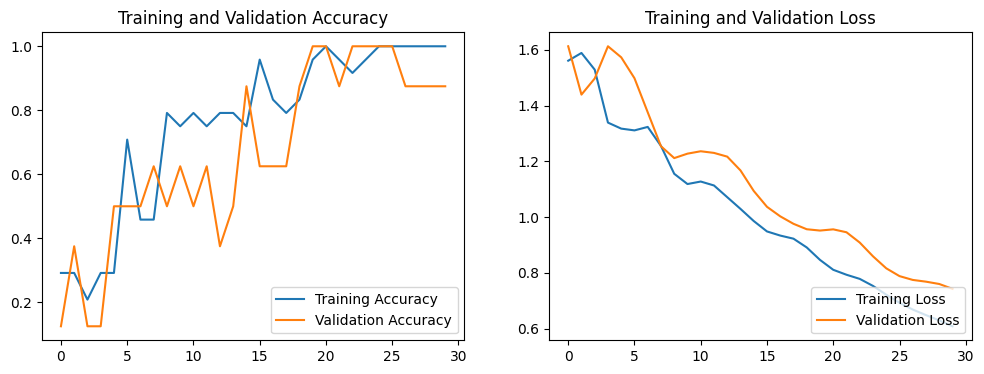

In [ ]:
plot_model(acuracia_treino, acuracia_valida, loss_treino, loss_valida, epocas)

Matriz de confusão para os resultados obtidos

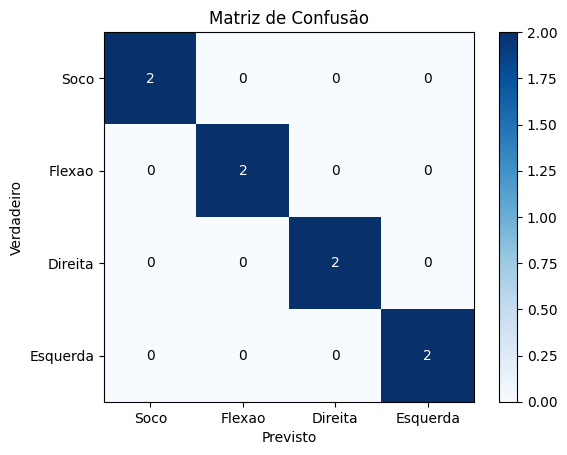

In [ ]:
y_true = esperado
y_pred = previsao

matriz_confusao(y_true, y_pred, gestos)

#### Modelo 2:
>*Otimizador: MSE*
<br>*Métrica: mae*
<br>*Batch_size: 8*
<br>*Épocas: 100*
<br>*Learning_rate: 0.001*
<br>*Camadas: 2 - 128 Neurônios | 4 Neurônios*

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)

DNN_model_MSE = tf.keras.models.Sequential([

    # Construção dos neurônios
    tf.keras.layers.Dense(128, activation = 'relu', input_shape = (X_train.shape[1],)),
    tf.keras.layers.Dense(len(gestos), activation = 'softmax')

])

DNN_model_MSE.compile(

    optimizer = tf.keras.optimizers.RMSprop(learning_rate = taxa_aprendizado),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['mae']

)

DNN_model_MSE.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                     │ (None, 128)                 │          91,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,036 (359.52 KB)

 Trainable params: 92,036 (359.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_DNN_MSE = DNN_model_MSE.fit(

    dataset_train,
    validation_data = dataset_validate,
    epochs = epocas

)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.2711 - mae: 0.4036 - val_loss: 0.2622 - val_mae: 0.4117
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2275 - mae: 0.3614 - val_loss: 0.2780 - val_mae: 0.4162
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1911 - mae: 0.3314 - val_loss: 0.3896 - val_mae: 0.4299
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2404 - mae: 0.3155 - val_loss: 0.3421 - val_mae: 0.4221
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2377 - mae: 0.3494 - val_loss: 0.2524 - val_mae: 0.3990
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2032 - mae: 0.3547 - val_loss: 0.2480 - val_mae: 0.4028
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1820 - mae: 0.3385 - val_loss: 0.2470 - val_mae: 0.3974
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1895 - mae: 0.3357 - val_loss: 0.2070 - val_mae: 0.3634
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2264 - mae: 0.3755

In [ ]:
results = DNN_model_MSE.evaluate(dataset_test, verbose=0)

dataset_test_loss = results[0]
dataset_test_mae = results[1]

dados_tab = [[np.around(dataset_test_loss, 4), np.around(dataset_test_mae, 4)]]

classes = ['Loss', 'MAE']
indices = ['Valor']

tabela = pd.DataFrame(dados_tab, index=indices, columns=classes)

display(tabela)

,Loss,MAE
Valor,0.0042,0.0512


In [ ]:
predictions = DNN_model_MSE.predict(X_test)
predictions = np.argmax(predictions, axis=1)

esperado = np.argmax(y_test, axis=1)

incremento = 0
previsao   = predictions

for i in range(len(previsao)):
  if previsao[i] == esperado[i]:
    incremento = incremento + 1

print('\nResultados Esperados: %s' % esperado)
print('\nResultados Previstos: %s' % predictions)
print('\nTeste teve {}% de aproveitamento\n'.format(round((incremento/len(previsao))*100,2)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

Resultados Esperados: [1 0 2 3 1 3 2 0]

Resultados Previstos: [1 0 2 3 1 3 2 0]

Teste teve 100.0% de aproveitamento



In [ ]:
with open('/content/history_DNN_MSE.pkl', 'wb') as f:
  pic.dump(history_DNN_MSE.history, f)

print(f"Histórico de treinamento salvo no Colab")

Histórico de treinamento salvo no Colab


In [ ]:
with open('/content/history_DNN_MSE.pkl', 'rb') as f:
  loaded_history = pic.load(f)

print(f"Histórico de treinamento carregado do Colab")

Histórico de treinamento carregado do Colab


In [ ]:
mae_treino = loaded_history['mae']
mae_valida = loaded_history['val_mae']

loss_treino = loaded_history['loss']
loss_valida = loaded_history['val_loss']

<Figure size 640x480 with 0 Axes>

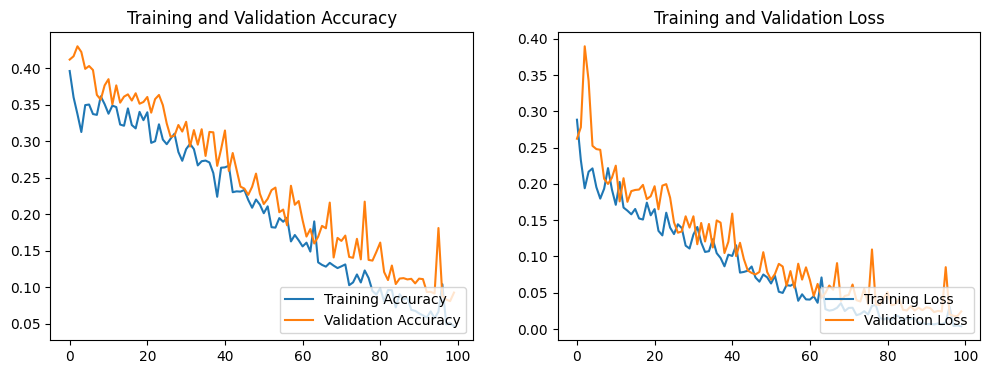

In [ ]:
plot_model(mae_treino, mae_valida, loss_treino, loss_valida, epocas)

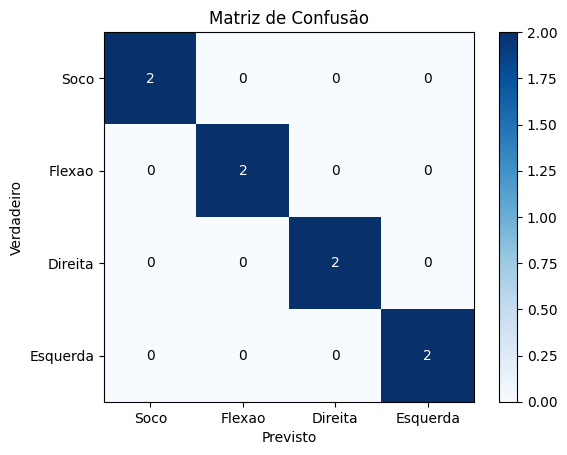

In [ ]:
y_true = esperado
y_pred = previsao

matriz_confusao(y_true, y_pred, gestos)

## Converte o modelo treinado em `nome_do_modelo.h`

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(DNN_model_MSE)
tflite_model = converter.convert()

open("gesture_model.tflite", "wb").write(tflite_model)

basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)

Saved artifact at '/tmp/tmpvhp71d_o'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 714), dtype=tf.float32, name='keras_tensor_33')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132625888567968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132625888570608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132625888561984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132625888989376: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model is 369876 bytes


In [ ]:
!echo "const unsigned char model[] = {" > /content/DNN_model_MSE.h
!cat gesture_model.tflite | xxd -i      >> /content/DNN_model_MSE.h
!echo "};"                              >> /content/DNN_model_MSE.h

import os
DNN_model_MSE_size = os.path.getsize("DNN_model_MSE.h")
print(f"Header file, DNN_model_MSE.h, is {DNN_model_MSE_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click DNN_model_MSE.h to download the file.")

Header file, DNN_model_MSE.h, is 2,280,936 bytes.

Open the side panel (refresh if needed). Double click DNN_model_MSE.h to download the file.
